<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw7/Homework7_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 260 (delta 61), reused 49 (delta 49), pack-reused 163
Receiving objects: 100% (260/260), 53.29 MiB | 33.01 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=aaa2895155aa44b021b0338a9bb0291e7f525fd31da94a518f4e20831fd09beb
  Stored in directory: /tmp/pip-ephem-wheel-cache-k5d81nn6/wheels/55/59/29/0fb1c635652157734

In [ ]:
from dul_2021.utils.hw7_utils import *

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


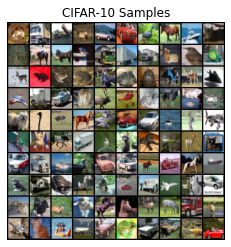

In [ ]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Upsample and Downsample convolutions

In [ ]:
!pip install einops

In [ ]:
import einops
import torch
import torch.nn as nn

class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        x = einops.rearrange(x, 'b (u v c) h w -> b c (h u) (w v)', u=2, v=2) # Depth2Space
        x = self.conv(x)
        return x


class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = einops.rearrange(x, 'b c (h u) (w v) -> b (u v) c h w', u=2, v=2)
        x = torch.mean(x, dim=1)
        x = self.conv(x)
        return x

## Resnet blocks

In [ ]:
class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size=(3, 3)):
        super().__init__()
        self.seq = nn.Sequential(nn.BatchNorm2d(in_dim),
                                 nn.ReLU(),
                                 nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                                 nn.BatchNorm2d(n_filters),
                                 nn.ReLU(),
                                 Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1))
                                 
        self.upsample = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        
    def forward(self, x):
        return self.seq(x) + self.upsample(x)


class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size=(3, 3)):
        super().__init__()
        self.seq = nn.Sequential(nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                                 nn.LeakyReLU(1e-1),
                                 Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1))
        
        self.downsample = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        
    def forward(self, x):
        return self.seq(x) + self.downsample(x)

class ResBlock(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size=(3, 3)):
        super().__init__()
        self.seq = nn.Sequential(nn.ReLU(),
                                 nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(n_filters, n_filters, kernel_size, padding=1))
        
    def forward(self, x):
        return self.seq(x) + x

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_filters=128, latent_dim=128):
        super().__init__()
        self.normal = torch.distributions.normal.Normal(0, 1)
        self.lat_dim = latent_dim
        self.counter = torch.tensor(0, dtype=torch.int)
        self.nfil = n_filters
        self.linear = nn.Linear(latent_dim, 4 * 4 * n_filters)
        
        self.generator = nn.Sequential(ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                                       ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                                       ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                                       nn.BatchNorm2d(n_filters),
                                       nn.ReLU(),
                                       nn.Conv2d(n_filters, 3, kernel_size=(3,3), padding=1),
                                       nn.Tanh())
       
    def sample_normal(self, upper_bound=4000):
        self.normal_z = self.normal.sample((upper_bound, self.lat_dim)).to(device)

    def forward(self, n_samples=1024):
        if self.counter == 0:
            self.sample_normal()
        self.counter = (self.counter + 1) % 10

        z = self.normal_z[self.counter * n_samples : (self.counter + 1) * n_samples]
        x = self.linear(z)
        x = x.reshape(-1, self.nfil, 4, 4)
        x = self.generator(x)
        return (x + 1) / 2

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_filters=128, latent_dim=128):
        super().__init__()
        
        self.res_seq = nn.Sequential(ResnetBlockDown(3, n_filters),
                                     ResnetBlockDown(n_filters, n_filters),
                                     ResBlock(n_filters, n_filters),
                                     ResBlock(n_filters, n_filters))

        self.lin = nn.Linear(n_filters, 1)

    def forward(self, image):
        x = self.res_seq(image)
        x = x.mean([2, 3])
        x = self.lin(x)
        return x

## Hyperparameters

In [ ]:
batch_size = 256
n_critic = 5
num_epochs = 40
λ = 10

## Load CIFAR data

In [ ]:
train_data = load_q1_data()

Files already downloaded and verified


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True)

## Define objects

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

G = Generator(192).to(device)
gen_opt = Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.9))
g_sched = StepLR(gen_opt, step_size=1, gamma=0.95)

D = Discriminator(192).to(device)
dis_opt = Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.9))
d_sched = StepLR(dis_opt, step_size=1, gamma=0.95)

## Image utils

In [ ]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [16., 16.]

In [ ]:
def get_image(generator):
    with torch.no_grad():
        im = generator(100)
    im = torch.permute(im, (0, 2, 3, 1))
    im = im.cpu().numpy() * 255
    im = im.astype(np.uint8)
    return im

def show_image(generator):
    images = get_image(generator)
    for i in range(10):
        for j in range(10):
            index = i * 10 + j
            plt.subplot(10, 10, index + 1)
            plt.imshow(images[index])
            plt.axis('off')
    plt.show()

## Training loop

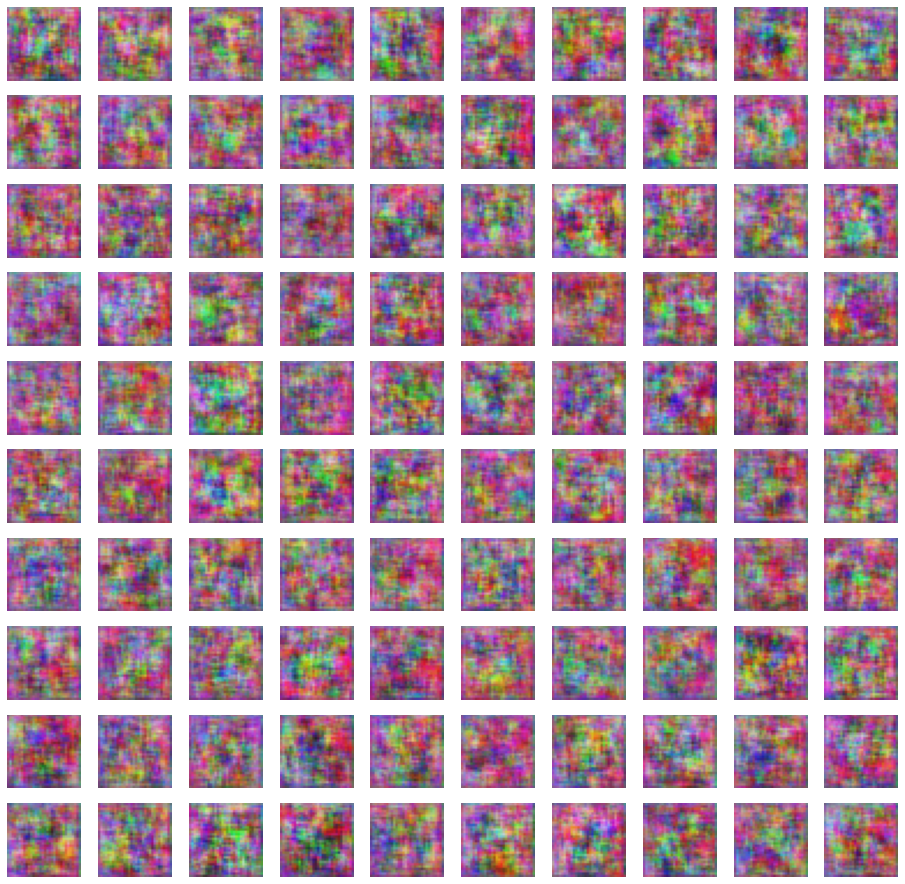

EPOCH 0
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -187491.4397506714
EPOCH 1
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -182245.03645420074
EPOCH 2
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -126823.86079478264
EPOCH 3
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -111137.5855884552


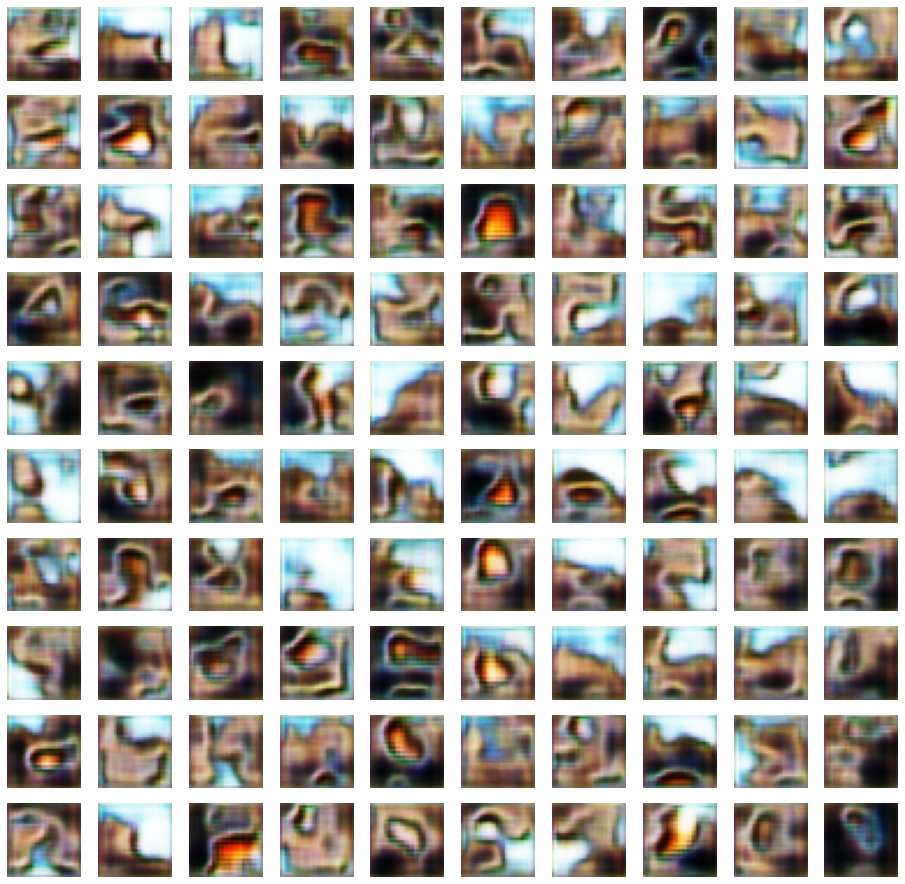

EPOCH 4
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -90302.57500219345
EPOCH 5
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -73680.94211292267
EPOCH 6
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -61000.0797662735
EPOCH 7
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -61272.85436916351


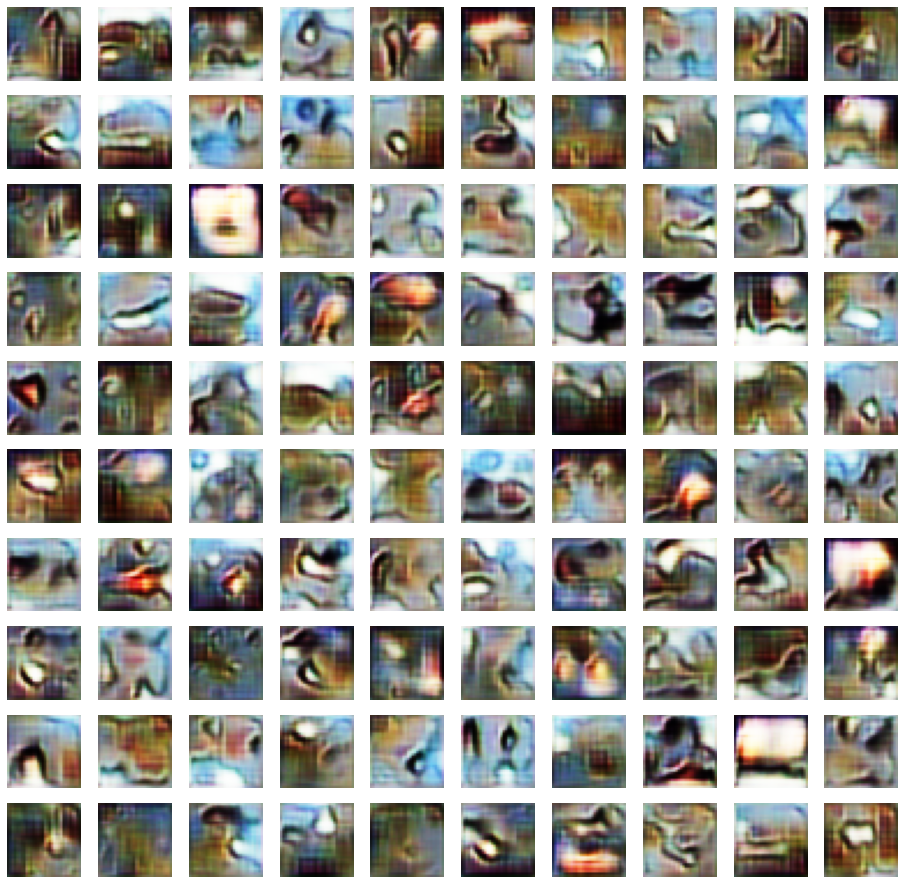

EPOCH 8
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -58039.700568675995
EPOCH 9
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -55687.40393567085
EPOCH 10
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -55063.74934411049
EPOCH 11
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -53909.36185646057


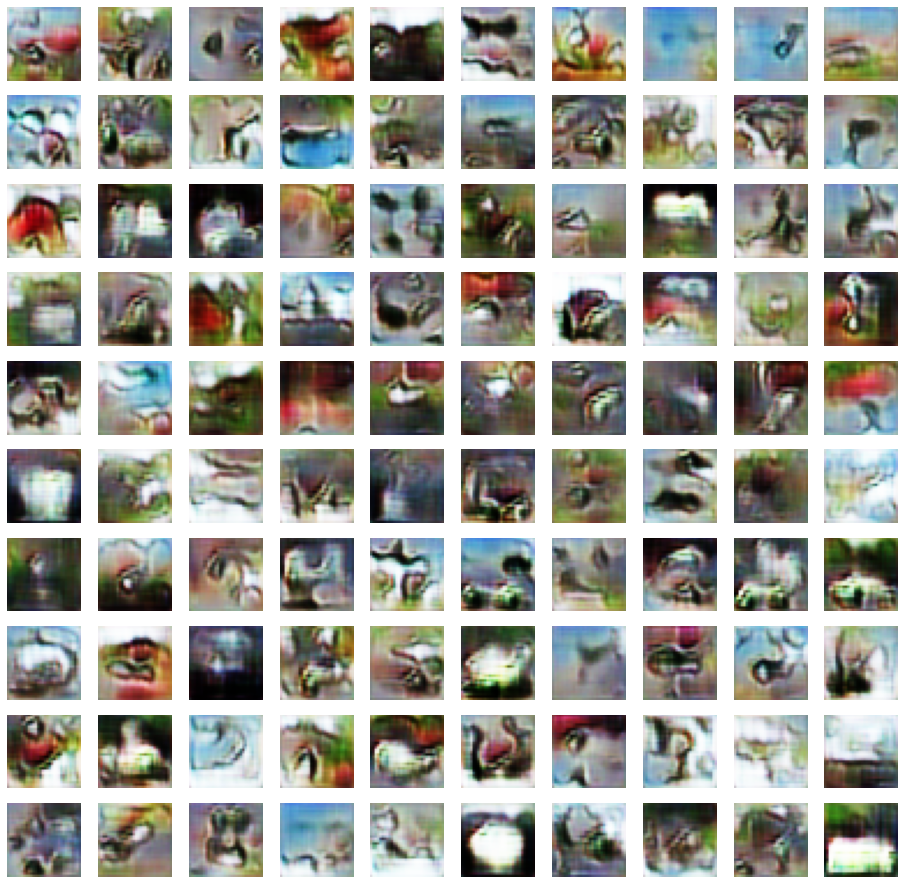

EPOCH 12
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -51482.39363002777
EPOCH 13
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -45457.05928182602
EPOCH 14
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -43232.26066660881
EPOCH 15
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -42449.88414812088


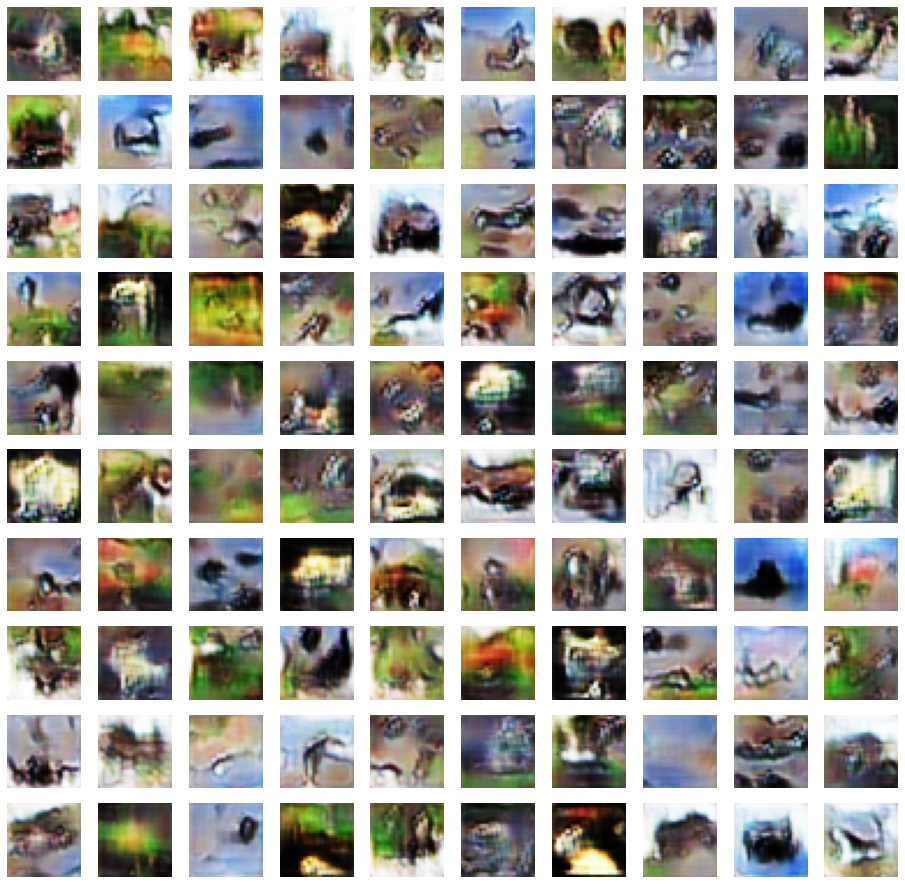

EPOCH 16
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -42948.81025695801
EPOCH 17
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -43730.713982105255
EPOCH 18
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -43746.51351594925
EPOCH 19
Batch #14
Batch #29
Batch #44
Batch #59
Batch #74
Batch #89
Batch #104
Batch #119
Batch #134
Batch #149
Batch #164
Batch #179
Batch #194
Loss = -44660.47644805908


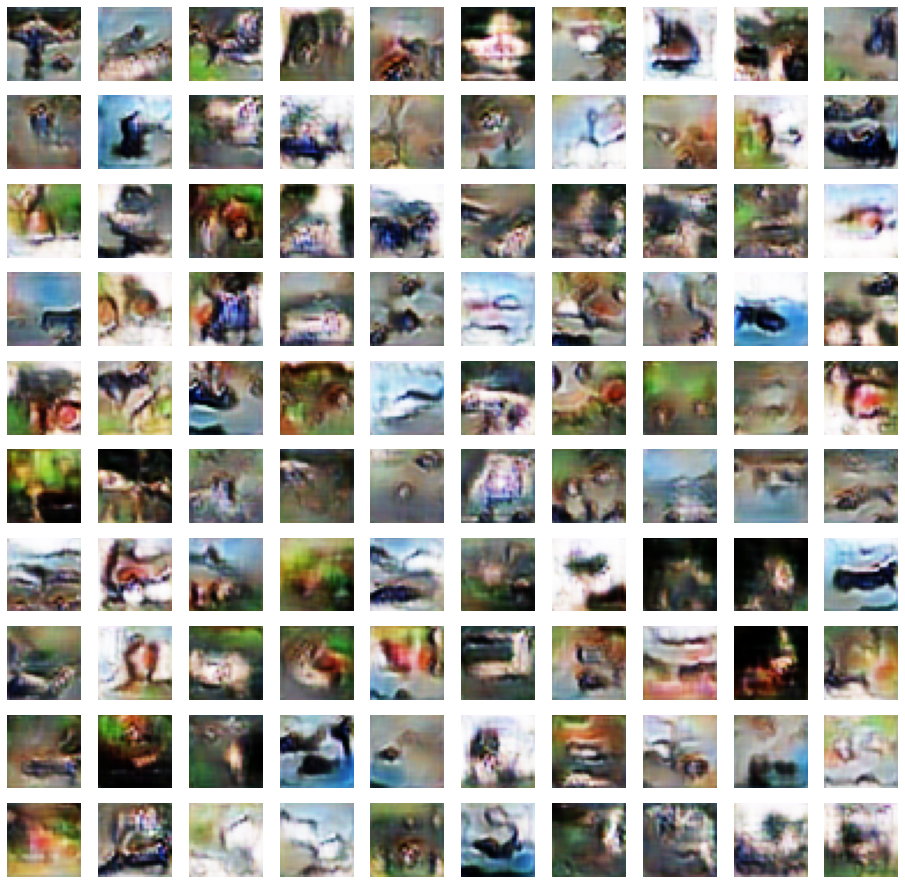

EPOCH 20


KeyboardInterrupt: ignored

In [ ]:
import numpy.random
from torch.distributions.uniform import Uniform

U = Uniform(0, 1)
grad_outputs = torch.ones((batch_size, 1), 
                          device=device, 
                          requires_grad=False)
loss_records = []

for epoch in range(num_epochs):
    if epoch % 4 == 0:
        show_image(G)

    epoch_loss_record = []
    print(f"EPOCH {epoch}")
    for t, batch in enumerate(train_dataloader):
        if (t + 1) % 15 == 0:
            print(f"Batch #{t}")
        
        size = batch[0].shape[0]
        x = batch[0].to(device)
        eps = U.sample((size, )).to(device)

        with torch.no_grad():
            x_gen = G(size)

        x_lin_sum  = torch.einsum('b, bchw -> bchw', eps, x)
        x_lin_sum += torch.einsum('b, bchw -> bchw', (1 - eps), x_gen)
        x_lin_sum.requires_grad = True

        gradient = torch.autograd.grad(D(x_lin_sum), x_lin_sum,
                                       grad_outputs=grad_outputs[:size],
                                       create_graph=True,
                                       retain_graph=True)[0]
    
        flat_grad = gradient.flatten(1, -1)
        grad_norm = torch.norm(flat_grad, dim=1, p=2)
        square_sum = (grad_norm - 1) ** 2

        d_loss = D(x_gen) - D(x) + λ * square_sum
        d_loss = d_loss.mean()
        #print(f"\t D-loss: {d_loss.item()}")
        loss_records.append(d_loss.item() * size)
        epoch_loss_record.append(loss_records[-1])

        dis_opt.zero_grad()
        d_loss.backward()
        dis_opt.step() 

        if (t + 1) % n_critic == 0:
            g_loss = - D(G(batch_size))
            g_loss = g_loss.mean()
            #print(f"\t G-loss: {g_loss.item()}")
            gen_opt.zero_grad()
            g_loss.backward()
            gen_opt.step()

    g_sched.step()
    d_sched.step()
    print(f"Loss = {sum(epoch_loss_record)}")

## Solution

In [ ]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    with torch.no_grad():
        im = G(1000)
    im = torch.permute(im, (0, 2, 3, 1))
    im = im.cpu().numpy()

    return loss_records, im

## Results

Files already downloaded and verified
..........Inception score: 5.10633


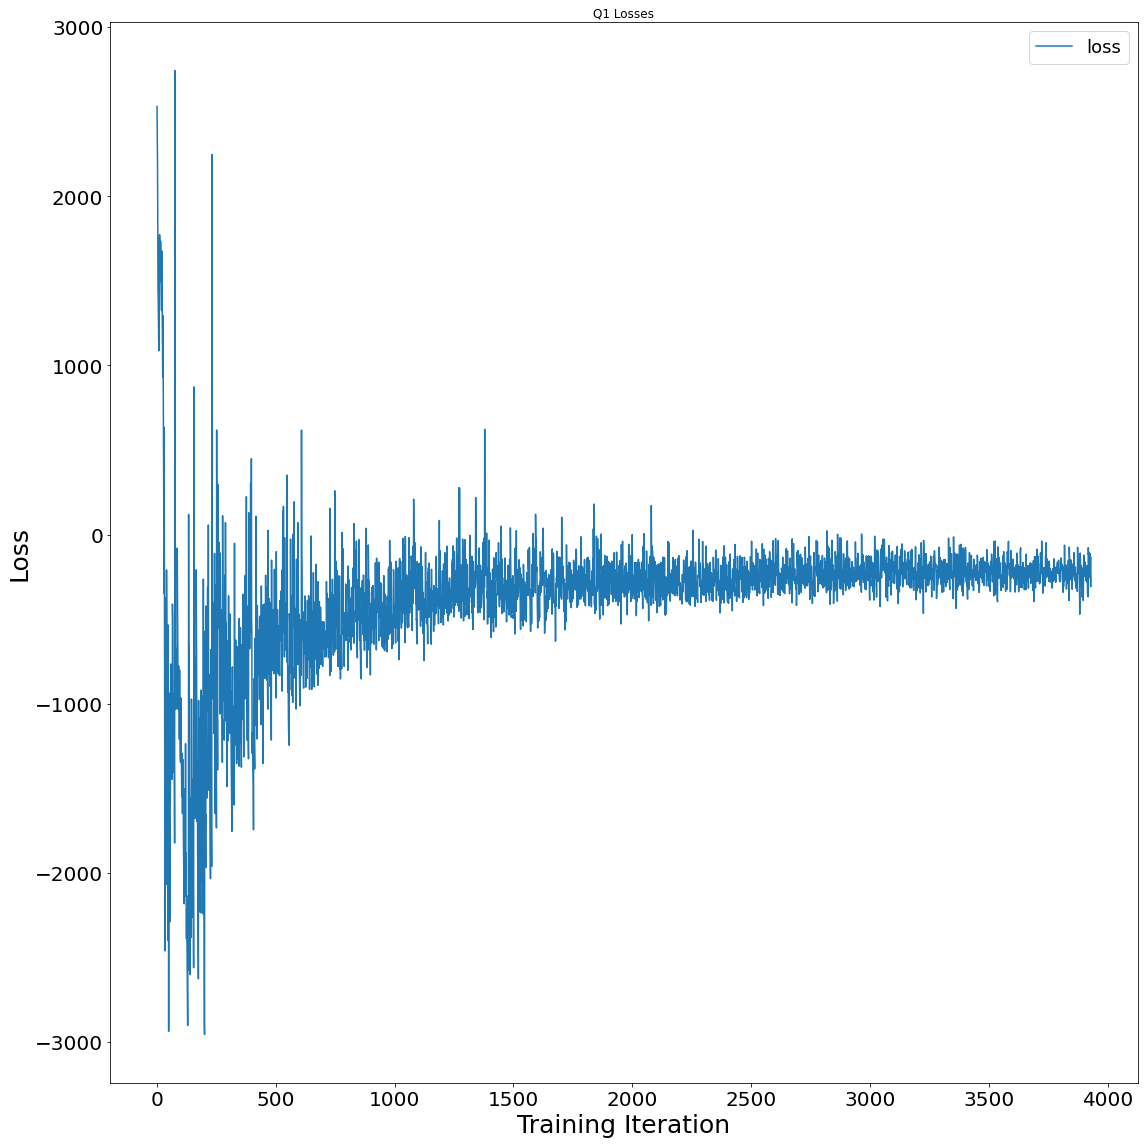

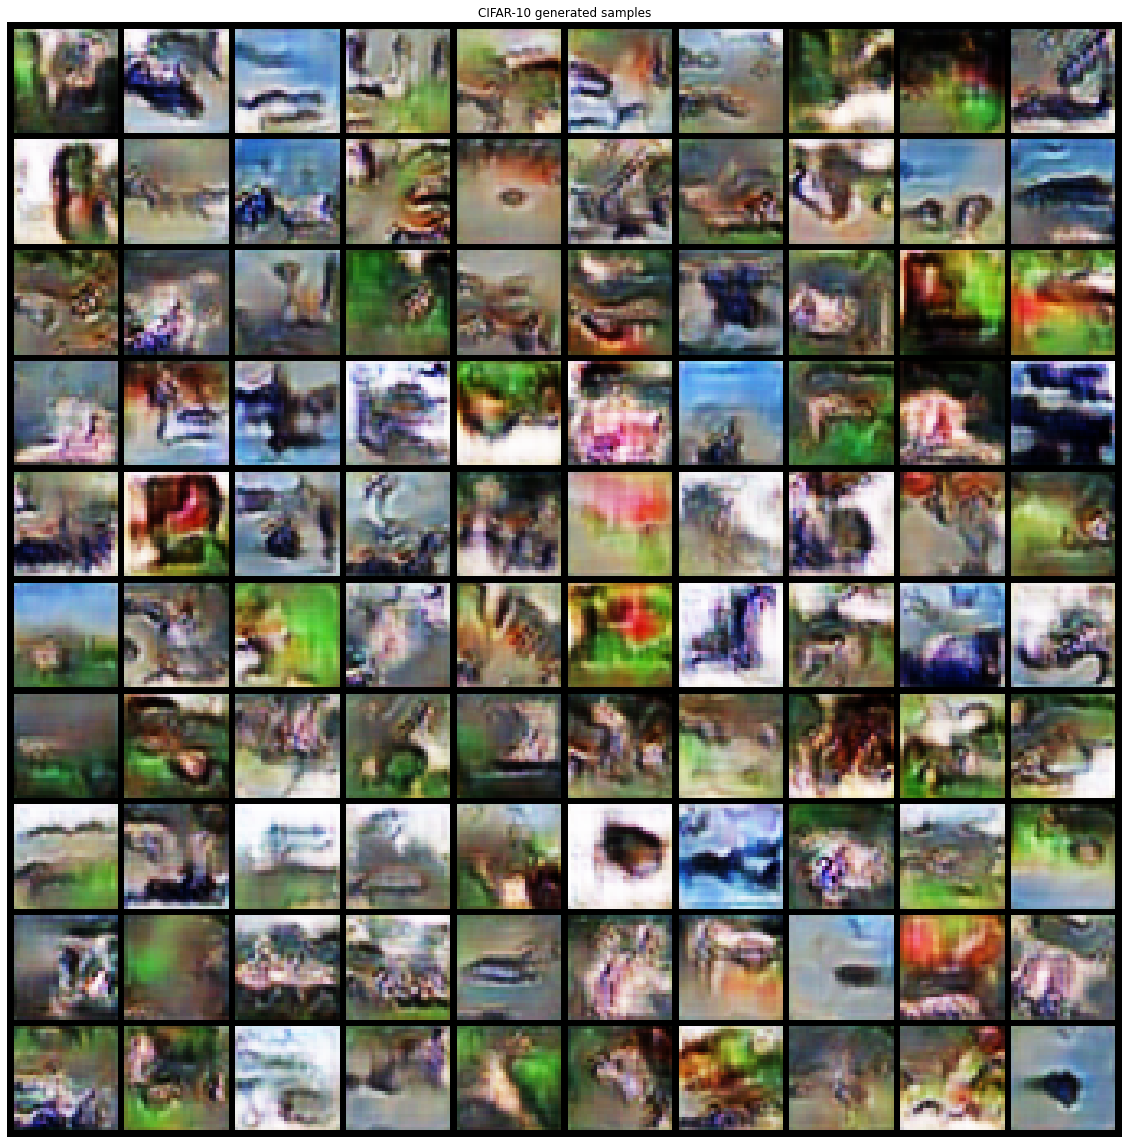

In [ ]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


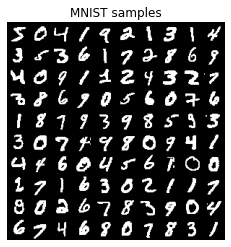

In [ ]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


In [ ]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [16., 16.]

In [ ]:
batch_size = 128
num_epochs = 100
n_critic = 5

In [ ]:
train_data, test_data = load_q2_data()
train_dl = torch.utils.data.DataLoader(train_data,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       pin_memory=True)
test_dl = torch.utils.data.DataLoader(test_data,
                                      batch_size=len(test_data),
                                      shuffle=True,
                                      pin_memory=True)

In [ ]:
def get_image(generator):
    normal = torch.distributions.normal.Normal(0, 1)
    z = normal.sample((100, 50)).to(device)
    with torch.no_grad():
        im = generator(z)
    #im = torch.permute(im, (0, 2, 3, 1))
    im = im.reshape(-1, 28, 28)
    im = im.cpu().numpy() / 2 + 0.5
    im *= 255
    im = im.astype(np.uint8)
    return im

def show_image(generator):
    images = get_image(generator)
    for i in range(10):
        for j in range(10):
            index = i * 10 + j
            plt.subplot(10, 10, index + 1)
            plt.imshow(images[index], cmap="gray")
            plt.axis('off')
    plt.show()

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, out_dim, hid_dim=1024, flag="G"):
        super().__init__()
        if flag == "G":
            non_lin_1 = nn.ReLU()
            non_lin_2 = nn.ReLU()
            non_lin_3 = nn.Tanh()
        else:
            non_lin_1 = nn.LeakyReLU(0.2)
            non_lin_2 = nn.LeakyReLU(0.2)
            if flag == "E":
                non_lin_3 = nn.LeakyReLU(1.0)
            else:
                non_lin_3 = nn.Sigmoid()

        self.seq = nn.Sequential(nn.Linear(input_dim, hid_dim),
                                 non_lin_1,
                                 nn.Linear(hid_dim, hid_dim),
                                 nn.BatchNorm1d(hid_dim),
                                 non_lin_2,
                                 nn.Linear(hid_dim, out_dim),
                                 non_lin_3)
        
    def forward(self, x):
        return self.seq(x)

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

In [ ]:
class BiGAN(nn.Module):
    def __init__(self, image_size=784, latent_dim=50):
        super().__init__()
        self.encoder = MLP(image_size, latent_dim, flag="E")
        self.enc_opt = Adam(self.encoder.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=2e-5)
        self.enc_sched = StepLR(self.enc_opt, step_size=1, gamma=0.95)

        self.generator = MLP(latent_dim, image_size)
        self.gen_opt = Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=2e-5)
        self.gen_sched = StepLR(self.gen_opt, step_size=1, gamma=0.95)

        self.discriminator = MLP(image_size + latent_dim, 1, flag="D")
        self.d_opt = Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=2e-5)
        self.d_sched = StepLR(self.d_opt, step_size=1, gamma=0.95)

        self.lat_dim = latent_dim
        self.normal = torch.distributions.normal.Normal(0, 1)
        self.flat = nn.Flatten()
    
    def sample(self, size):
        normal_z = self.normal.sample((size, self.lat_dim)).to(device)
        return normal_z, self.generator(normal_z)

    def forward(self, x):
        x = self.flat(x)
        z = self.encoder(x)
        real = torch.cat((z, x), dim=1)

        u, v = self.sample(x.shape[0])
        gen = torch.cat((u, v), dim=1)

        return real, gen

In [ ]:
bgan = BiGAN().to(device)
ones = torch.ones(batch_size, device=device).unsqueeze(1)
zeros = torch.zeros(batch_size, device=device).unsqueeze(1)
bce = nn.BCELoss()

In [ ]:
loss_record = []

for epoch in range(num_epochs):
    show_image(bgan.generator)
    D = bgan.discriminator
    print(f"Epoch #{epoch}")
    for b_num, (image, _) in enumerate(train_dl):
        image = image.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            r, g = bgan(image)

        loss_1 = bce(D(r), zeros[:image.shape[0]]) + bce(D(g), ones[:image.shape[0]])
        loss_1 = -loss_1

        bgan.d_opt.zero_grad()
        loss_1.backward()
        bgan.d_opt.step()

        loss_record.append(loss_1.item())
        if (b_num + 1) % n_critic == 0:
            r, g = bgan(image)
            loss_2 = bce(D(r), zeros[:image.shape[0]]) + bce(D(g), ones[:image.shape[0]])

            bgan.enc_opt.zero_grad()
            bgan.gen_opt.zero_grad()

            loss_2.backward()

            bgan.enc_opt.step()
            bgan.gen_opt.step()
    
    bgan.enc_sched.step()
    bgan.d_sched.step()
    bgan.gen_sched.step()

    # Reconstruction check after every epoch
    p = np.random.permutation(10_000)[:10]
    r_images = torch.zeros((10, 28, 28))
    for j, q in enumerate(p):
        r_images[j] = test_data[q][0]

    r_images = r_images.to(device)

    with torch.no_grad():
        f_images = bgan.flat(r_images)
        z =  bgan.encoder(f_images)
        rec = bgan.generator(z)
        
    rec = rec.reshape(-1, 28, 28)
    rec = rec.cpu().numpy() / 2 + 0.5
    rec *= 255
    rec = rec.astype(np.uint8)

    r_images = r_images.reshape(-1, 28, 28)
    r_images = r_images.cpu().numpy() / 2 + 0.5
    r_images *= 255
    r_images = r_images.astype(np.uint8)

    for j in range(10):
        plt.subplot(2, 10, 2*j + 1)
        plt.imshow(r_images[j], cmap="gray")
        plt.axis('off')

        plt.subplot(2, 10, 2*j + 2)
        plt.imshow(rec[j], cmap="gray")
        plt.axis('off')

    plt.show()

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, latent_dim=50, num_of_classes=10):
        super().__init__()
        self.linear = nn.Linear(latent_dim, num_of_classes)
        self.CEL = nn.CrossEntropyLoss()
        self.opt = Adam(self.linear.parameters())

    def forward(self, x):
        return self.linear(x)

    def update(self, x, y):
        """
        Arguments:
          x -- logits
          y -- true labels
        Take gradient step.
        """
        loss = self.CEL(x, y)

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

In [ ]:
def train_classifier(encoder, lin_classifier, train_dl, test_dl, num_epochs=20):
    cross_entropy = np.zeros(num_epochs)
    flat = nn.Flatten()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}")
        for images, labels in train_dl:
            labels = labels.to(device)
            images = images.to(device)
            with torch.no_grad():
                images = flat(images)
                z = encoder(images)
        
            z.requires_grad = True
            logit = lin_classifier(z)
            lin_classifier.update(logit, labels)
        
        for images, labels in test_dl:
            images = images.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                images = flat(images)
                z = encoder(images)
                logit =  lin_classifier(z)
                cross_entropy[epoch] = lin_classifier.CEL(logit, labels).item()
        print(f"\tloss = {cross_entropy[epoch]}")

    return cross_entropy

In [ ]:
# Linear classifier on trained encoder
classifier_1 = LinearClassifier().to(device)

loss_trained = train_classifier(bgan.encoder, classifier_1, train_dl, test_dl, 20)

Epoch 0
	loss = 0.8763378858566284
Epoch 1
	loss = 0.7021656036376953
Epoch 2
	loss = 0.631698489189148
Epoch 3
	loss = 0.5943291783332825
Epoch 4
	loss = 0.5695887804031372
Epoch 5
	loss = 0.5509639978408813
Epoch 6
	loss = 0.5361332297325134
Epoch 7
	loss = 0.5260654091835022
Epoch 8
	loss = 0.5182260274887085
Epoch 9
	loss = 0.5094875693321228
Epoch 10
	loss = 0.5028225779533386
Epoch 11
	loss = 0.49717867374420166
Epoch 12
	loss = 0.49261966347694397
Epoch 13
	loss = 0.4866059124469757
Epoch 14
	loss = 0.4849695861339569
Epoch 15
	loss = 0.48002612590789795
Epoch 16
	loss = 0.4752947688102722
Epoch 17
	loss = 0.472929447889328
Epoch 18
	loss = 0.4693201184272766
Epoch 19
	loss = 0.4669138789176941


In [ ]:
# Linear classifier on random encoder
classifier_2 = LinearClassifier().to(device)
random_encoder = MLP(28 * 28, 50).to(device)

loss_random = train_classifier(random_encoder, classifier_2, train_dl, test_dl, 20)

Epoch 0
	loss = 1.3440645933151245
Epoch 1
	loss = 1.0533784627914429
Epoch 2
	loss = 0.9294689297676086
Epoch 3
	loss = 0.8609472513198853
Epoch 4
	loss = 0.8179996013641357
Epoch 5
	loss = 0.7888731360435486
Epoch 6
	loss = 0.7684434652328491
Epoch 7
	loss = 0.7533060312271118
Epoch 8
	loss = 0.7417970895767212
Epoch 9
	loss = 0.733113706111908
Epoch 10
	loss = 0.7266185283660889
Epoch 11
	loss = 0.7210845947265625
Epoch 12
	loss = 0.7169550657272339
Epoch 13
	loss = 0.7128452062606812
Epoch 14
	loss = 0.7100861668586731
Epoch 15
	loss = 0.7073665261268616
Epoch 16
	loss = 0.7056273221969604
Epoch 17
	loss = 0.7035163640975952
Epoch 18
	loss = 0.7018228769302368
Epoch 19
	loss = 0.7016171813011169


## Solution

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """
    
    # Reconstructions
    r_images = torch.zeros((20, 28, 28))
    for j in range(20):
        r_images[j] = test_data[j][0]

    r_images = r_images.to(device)

    with torch.no_grad():
        f_images = bgan.flat(r_images)
        z =  bgan.encoder(f_images)
        rec = bgan.generator(z)

    rec = rec.reshape(-1, 28, 28)
    rec = rec.cpu().numpy() / 2 + 0.5

    r_images = r_images.reshape(-1, 28, 28)
    r_images = r_images.cpu().numpy() / 2 + 0.5

    rec_pairs = np.zeros((40, 28, 28))
    for i in range(20):
        rec_pairs[i] = r_images[i]
        rec_pairs[20 + i] = rec[i]
    
    rec_pairs = np.expand_dims(rec_pairs, 3)

    # Samples
    with torch.no_grad():
        _, samples = bgan.sample(100)
    samples = samples.reshape(-1, 1, 28, 28)
    samples = samples.cpu().numpy() / 2 + 0.5
    samples = samples.reshape(100, 28, 28, 1)

    return loss_record, samples, rec_pairs, loss_trained, loss_random

## Results

Rec pairs = (40, 28, 28, 1)
Shape = (100, 28, 28, 1)


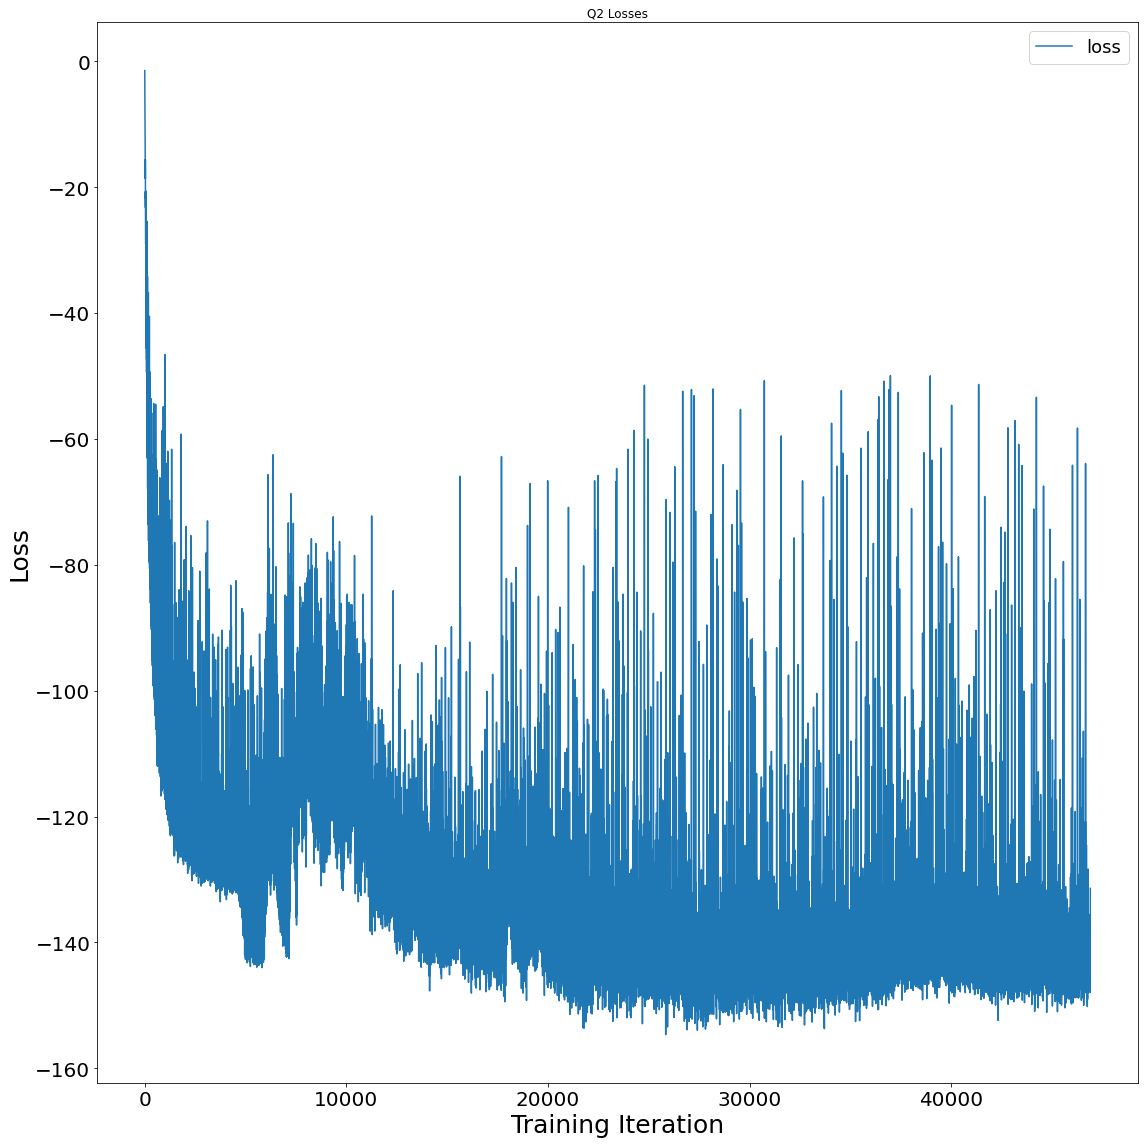

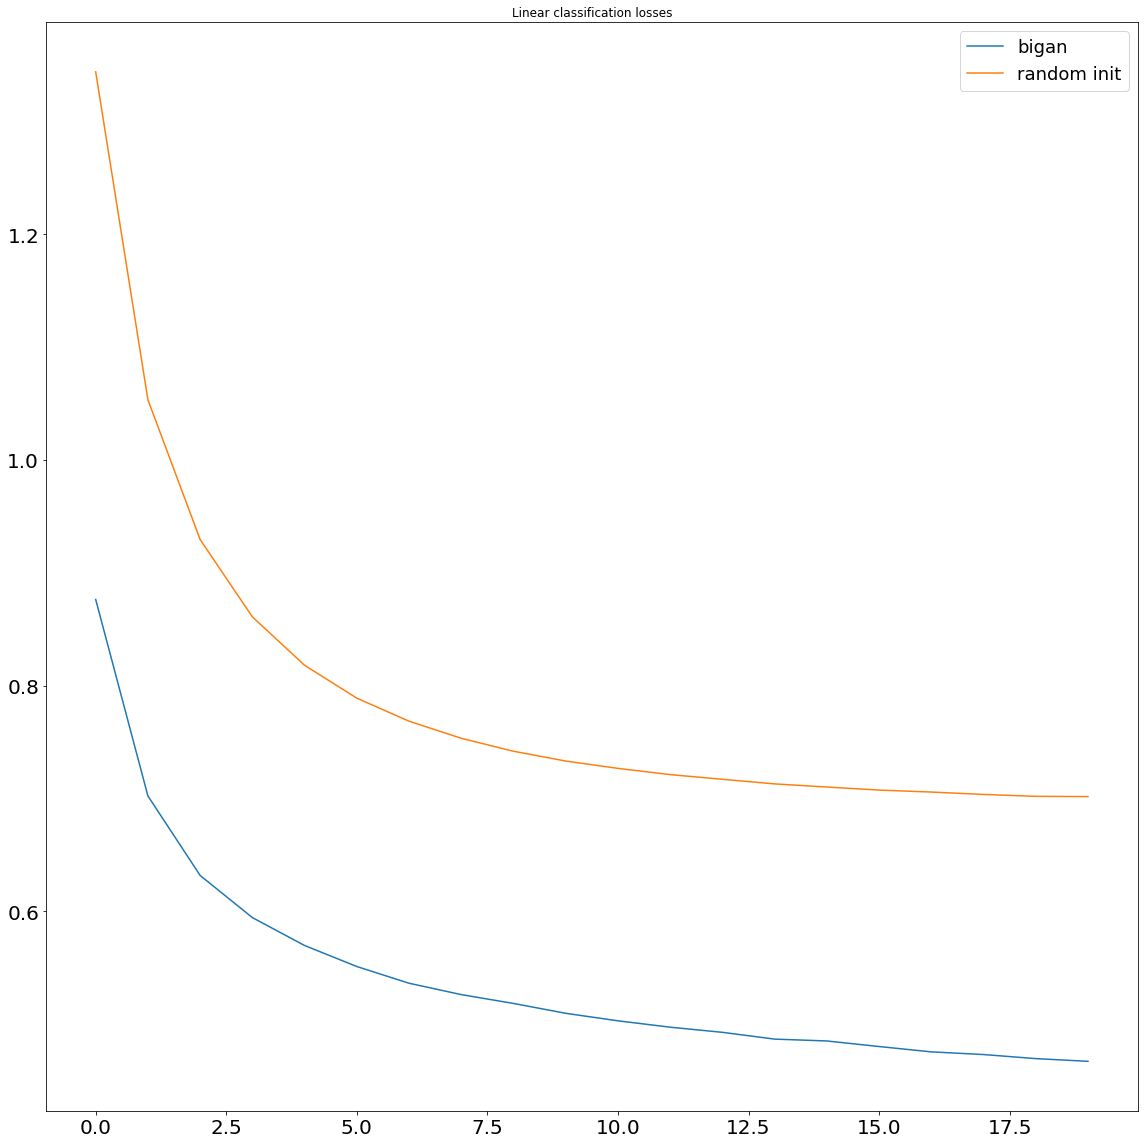

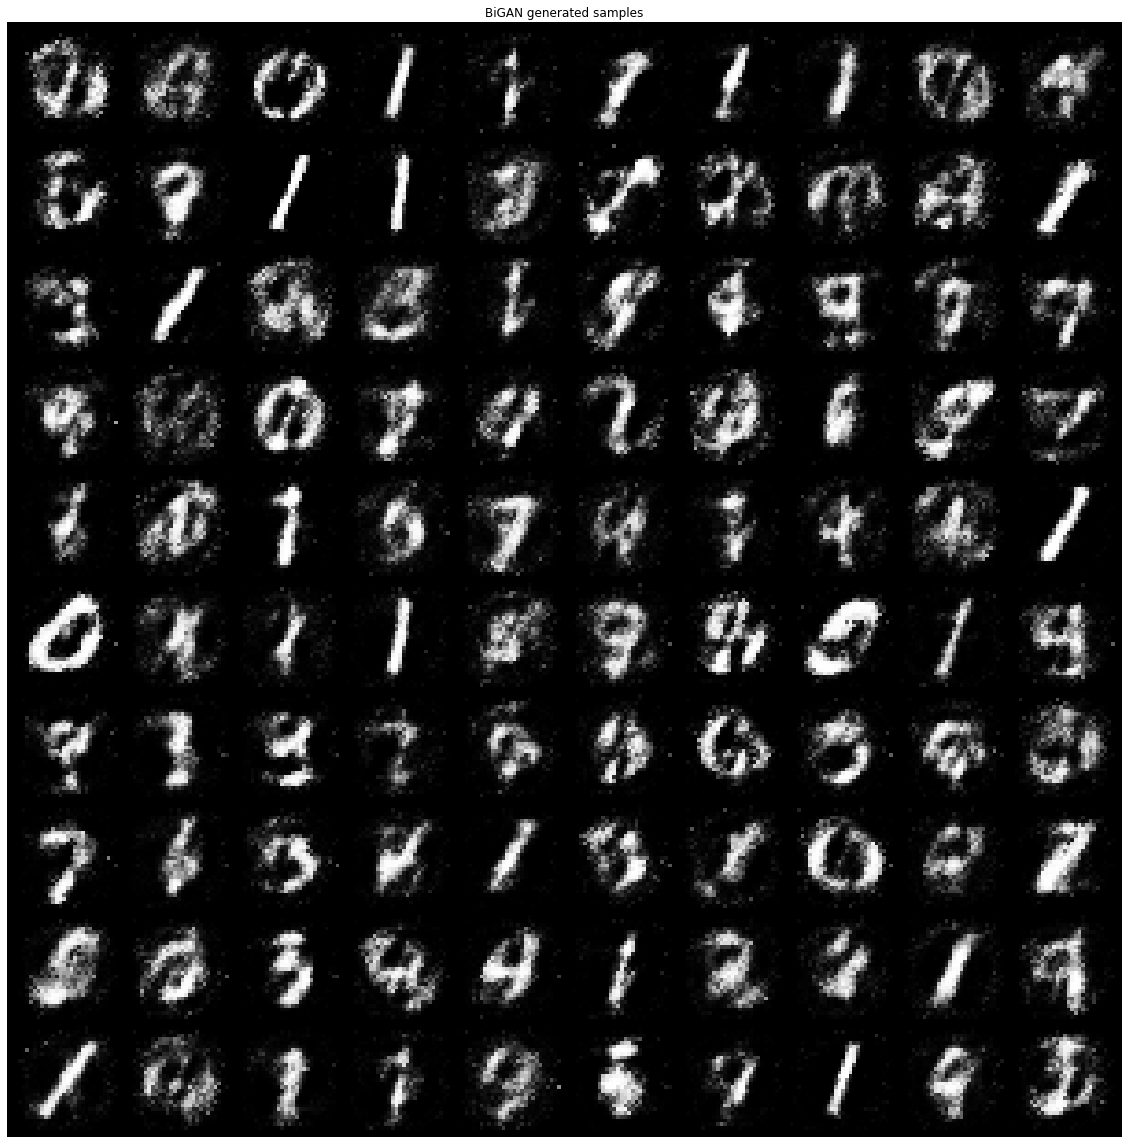

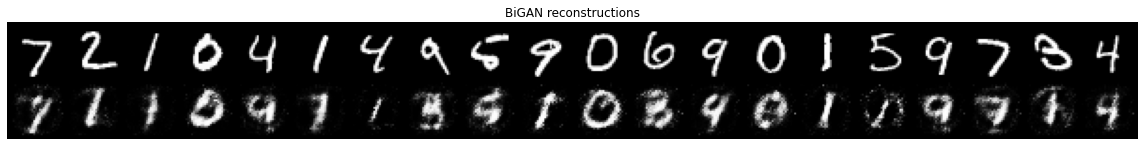

BiGAN final linear classification loss: 0.4669138789176941
Random encoder linear classification loss: 0.7016171813011169


In [ ]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

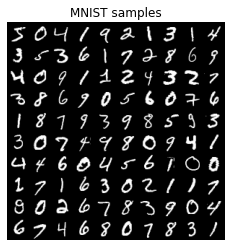

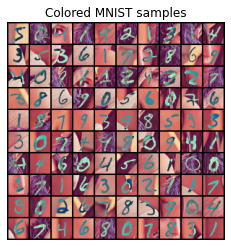

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

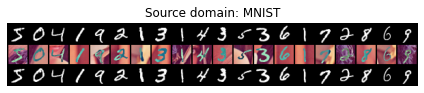

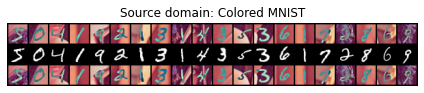

In [ ]:
b5_save_results(b5)